In [18]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import colors as mcolors
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import pandas as pd
import numpy as np
import scipy as sc
from scipy.optimize import curve_fit
import datetime 
from datetime import timedelta
import math
import configparser
from configparser import ConfigParser 
import seaborn as sns; sns.set()
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import tkinter as tk
from tkinter import ttk
from tqdm.gui import trange, tqdm, tqdm_gui
import tkinter.scrolledtext as tkst
import warnings
warnings.filterwarnings("ignore")
import tkinter as tk
from tkinter import messagebox, simpledialog, ttk
from tkinter import filedialog as fd 
from tkinter.filedialog import asksaveasfile , asksaveasfilename
try:
    from tabulate import tabulate
except:
    print('Please install the package tabulate')

In [37]:
def quad_experiment(KD,c_max=10,n_c=6):
    '''
    creates a list of concentrations which quadratically rising between 
    the concentration c_start and c_max and zero.
    
    inputs:
    KD, dissociation constant as float
    c_max highest ligand concentration in multiples of KD as float
    n_c: number of different concentrations as int
    
    return set of concentrations as array
    
    '''
    
    c_start = c_max / 2**(n_c-2)
    
    c_single_list = [c_start * 2**i * KD for i in range(n_c-1)]
    return np.concatenate([[0],c_single_list])
    
def alpha_to_c(KD,alpha):
    
    '''
    recalculation of c from alpha with given KD
    
    alpha = c/(KD+c)
    
    KD*alpha/(1-alpha) = c
    
    input
    KD as float, alpah as float betwenn 0 and 1
    
    return c as float
    
    
    test:
    
    alpha_to_c(10,0.68) = 21.05
    
    21.25/(10+21.25) = 0.68
    '''
    
    return KD*alpha/(1-alpha)


def inv_lin_experiment(KD,c_max,n_c=6,alpha_low=0):
    
    '''
    creates a list of concentrations which are linearly equal spaced on the alpha scale
    
    inputs:
    KD, dissociation constant as float
    c_max highest ligand concentration in multiples of KD as float
    n_c: number of different concentrations as int
    
    alpha_low: start point of concentration range in alpha as float between 0 and 1
    
    return set of concentrations as array
    '''
    
    c_max_c = c_max * KD
    alpha_max= c_max_c /(KD+c_max_c)
    alpha_list = np.linspace(alpha_low,alpha_max,n_c)
    
    
    c_single_list = [alpha_to_c(KD,x) for x in alpha_list]

    return c_single_list

def C_set(KD,c_max,resolution=20,include_zero = True,log_c_min=-1):
    
    """
    this function defines the set of concentration values
    
    
    KD, dissociation constant as float
    c_max highest ligand concentration in multiples of KD as float
    
    log_c_min: log10 start value of the set

    Resolution: number of values per log unit
    
    return: numpy array of the C_set
    """
    
    log_c_max = np.log10(c_max*KD)
    
    c_range = int((log_c_max - log_c_min ) *resolution +1)

    
    c_set = np.array(np.logspace(log_c_min,log_c_max,c_range))
    
    if include_zero:
        c_set = np.concatenate([[0],c_set])
    
    return c_set

def ms_ACE_no_eta_KD(c,uf,uc,KD):
    
    '''
    Implementation of the ms-ACE model function
    without viscosity correction
    
    inputs:
            c: ligand concentration as float
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
            
    return:
            ui:mobility at concentration = c as float
    '''
    
    return uf + ((uc-uf)*c)/(KD+c)


def ms_ACE_no_eta(c,KD,uc,uf):
    '''

    Implementation of the ms-ACE model function
    without viscosity correction
    based on KA
    
    inputs:
            c: ligand concentration as float
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
            
    return:
            ui:mobility at concentration = c as float

    '''
    
    KA = 1/KD
    
    u_i = (uf + KA * uc *c)/(1+KA*c)
    
    return u_i


def variance_function_ms_ACE(c,beta0,beta1):
    
    '''
    Implementation variance function. Can be used to prdict the variance of ui.
    
    inputs: 
            c: ligand concentration as float
            beta0 and beta1: experimental coefficients as float
            
    return:
            predicted variance at c as float
    
    '''
    
    predicted_var = beta0 *np.exp(beta1 * c)
    
    return predicted_var



def duf(c,uf,uc,KD):
    
    '''
    Partial derivative function of the ms ACE model function 
    with respect to uf.
    inputs:
            c: ligand concentration as float
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
    
    return:
            partial deriviative evaluated at c as float
    
    
    '''
    
    return KD/(c+KD)

def duc(c,uf,uc,KD):
    '''
    Partial derivative function of the ms ACE model function 
    with respect to uc.
    inputs:
            c: ligand concentration as float
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
    
    return:
            partial deriviative evaluated at c as float
    
    '''
    
    return c/(c+KD)


def dKD(c,uf,uc,KD):
    '''
    Partial derivative function of the ms ACE model function 
    with respect to KD.
    inputs:
            c: ligand concentration as float
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
    
    return:
            partial deriviative evaluated at c as float
    
    
    '''
    
    return ((uf-uc)*KD)/ (c+KD)**2

def Information_matrix_single (c,uf,uc,KD):
    """
    
    calculation of the fisher information matrix
    
    A[1:i] = [df/dt_1,...,df/dt_i]
    dt_i: partial derivation of the function f to the i-th parameter
    of the parameter vector T = [t_1,...,t_i]^T
    A_T[i:1] = transpose of A
    fisher-information matrix of a single value
    I[i:i] = A_T * A
    
    
    ------------------------------------------------------------------------------------
    
    Inputs for global_derivitive_functions: (c_value, t_value,chemical_parameter)
    
    ------------------------------------------------------------------------------------

    
    return: I the fisher information matrix of a single value

    """
    
    
    global_derivitive_functions = [duf,duc,dKD]
    
    A = np.mat([global_derivitive_functions[i](c,uf,uc,KD) for i in range(3)])
    
    A_T = A.getT()
    
    I = np.matmul(A_T,A)
    
    
    return I


def Information_matrix_set(c_list,uf,uc,KD):
    
    """

    calculation of the total fisher information matrix 

    single I :
    A[1:i] = [df/dt_1,...,df/dt_i]
    dt_i: partial derivation of the function f to the i-th parameter
    of the parameter vector T = [t_1,...,t_i]^T
    A_T[i:1] = transpose of A
    fisher-information matrix of a single value
    I[i:i] = A_T * A

    total I :
    I_total = sum(I)

    M = 1/n I_total
    where n is the number of c_values in c_list



    ------------------------------------------------------------------------------------
    c_list: input concentration list

    chemical parameter: list of Theta values

    return: [0] I: fisher information matrix of all values
            [1] M: fisher information matrix of all values normalized by n

    """


    n = len(c_list)

    I = np.zeros((3,3))

    for c_value in c_list:

        I += Information_matrix_single (c_value,uf,uc,KD)

    M = I/n

    return I,M


def optimality(M, optimality_parameter = 'D'):
    
    '''
    calculation of the optimality parameter
    
    Inputs: M or I as matrix/array
            where
                I: Fisher Inforamtion Matrix or
                M: the average per observation information matrix
                
            optimality_parameter: 'D', 'E' or 'A' as str
            defines the type of computes optimality measure
            D: D-optimal determinate of inverse M, expressed as log
            E: E-optimal maximal Eigenvalue of inverse M
            A: A-optimal trace of inverse M
    
    Return: Measure of optimality as float
        
    
    
    '''
    
    
    M_inv = np.linalg.pinv(M, rcond=1e-15, hermitian=False)
    
    
    if optimality_parameter == 'D':
         opt = np.log(np.linalg.det(M_inv))
            
    elif optimality_parameter == 'A':
        
        opt = np.trace(M_inv)
        
    elif optimality_parameter == 'E':
        E = np.linalg.eigvals(M_inv)
    
        opt = np.amax(E)
        
    
    return opt

def delta_opt_minus(c_list_df,c_rest_df,uf,uc,KD,opt_mode,k_factor=3):
    
    
    '''
    Step 01 of the k-fold algorithm for the definition of optimal concentration sets.
    
    The algorithm takes an initial set of c values and defines its optimality. Subsequently 
    every entry of this set is replaced by every member of an alternative set. This set results 
    from a random selection from the rest of all possible values. The size of this selection is
    defined by the k-factor. The optimality is calculated for every new set and the one with the
    best optimality is defined as new concentration set. The excluded c is added to the rest set.
    
    Inputs:
            c_list_df: present concentration set as pandas DataFrame
            c_rest_df: rest concentration set, all possible values - c_list_df as pandas DataFrame
  
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
            
            opt_mode: optimality_parameter as 'D', 'E' or 'A' 
            k_factor: defines the split of the rest concentration set
            
    return: new_c_list_df: new concentration set as pandas DataFrame
            new_c_rest: new rest concentration set as pandas DataFrame
            opt_new: optimality measure of the new_c_list_df as float
            opt_begin: optimality measure of the c_list_df as float
            c_out: excluded c value as float
            c_in: excluded c value as float
            Delta_max: Differenz of the optimality measures from opt_new vs. new_c_list_df as float          
            
    
    '''
    
    
    Delta_list = {'c_out':[],'c_in':[],'index_out':[],'index_in':[],'opt':[],'Delta':[]}
    
    K_sample_size = int(len(c_rest_df)/k_factor)
    
    C_rest_K = c_rest_df.sample(K_sample_size)
    
    M = Information_matrix_set(c_list_df['c'],uf,uc,KD)[1]
    
    
    
    opt_begin =  optimality(M, optimality_parameter = opt_mode)
    

    for i in range(len(c_list_df)):

            index_out = c_list_df.index[i]

            reduced_c_list = c_list_df.drop(index_out)
            
            c_out = c_list_df['c'][index_out]
            
            for j in range(len(C_rest_K)):
                
                index_in = C_rest_K.index[j]

                c_in_df = C_rest_K.filter(items=[index_in],axis=0)

                stocked_list = pd.concat([reduced_c_list, c_in_df], ignore_index=False)
                
                c_in = c_in_df['c'][index_in]

                Delta_list['c_out'].append(c_out)
                Delta_list['index_out'].append(index_out)

                Delta_list['c_in'].append(c_in)
                Delta_list['index_in'].append(index_in)

                M_ij = Information_matrix_set(stocked_list['c'],uf,uc,KD)[1]
                opt_ij = optimality(M_ij, optimality_parameter = opt_mode)
                Delta_opt =  opt_ij - opt_begin 
                
                Delta_list['opt'].append(opt_ij)
                Delta_list['Delta'].append(Delta_opt)

            
            
    Delta_list_df = pd.DataFrame(Delta_list)

    index_delta_opt_min = Delta_list_df['opt'].argmin()

    index_min_out =  Delta_list_df['index_out'][index_delta_opt_min]

    index_min_in =  Delta_list_df['index_in'][index_delta_opt_min]

    c_out = c_list_df['c'][index_min_out]

    c_out_df = c_list_df.filter(items=[index_min_out],axis=0)

    c_in = C_rest_K['c'][index_min_in]

    c_best_red = c_list_df.drop(index_min_out) 

    c_in_df = C_rest_K.filter(items=[index_min_in],axis=0)

    new_c_list_df = pd.concat([c_best_red, c_in_df], ignore_index=False)

    new_c_rest_red = c_rest_df.drop(index_min_in)

    new_c_rest = pd.concat([new_c_rest_red, c_out_df], ignore_index=False)

    opt_new =   Delta_list_df['opt'][index_delta_opt_min]
    
    Delta_max = Delta_list_df['Delta'][index_delta_opt_min]
    

        
    return new_c_list_df, new_c_rest, opt_new,opt_begin, c_out, c_in, Delta_max

def opt_loop(c_total_in_df,uf,uc,KD,k_factor,opt_mode,no_c,change_threshold=0,multiply=None):
    
    '''
    Step 02 of the k-fold algorithm for the definition of optimal concentration sets.
    
    Repeats step 01 until the change of optimality reaches a defined threshold.
    
    Inputs:
            c_total_in_df: all possible candidates of the concentration set as pandas DataFrame
  
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
            
            opt_mode: optimality_parameter as 'D', 'E' or 'A' 
            k_factor: defines the split of the rest concentration set
            
            no_c: number of entries in the desired concentration set as int
            change_threshold: stops the iteration if the change in optimality is not smaller than the threshold as float
            multiply: Defines the maximal number of repeated values within the set as int
            
    return: track_df: DataFrame with all important measures of the iteration as pandas DataFrame
    
                        within the DataFrame: 
                            iteration: counter of iterations as int
                            c_set: current concentration set as list
                            opt_value: optimality measure of thec_set as float
                           
                            c_out: excluded c value as float
                            c_in: excluded c value as float
                            Delta_opt: Differenz of the optimality measures from c_set vs. previous set as float       
    
    '''
    

    track_dict = {'iteration':[0], 'c_set':[],'opt_value':[np.nan],'c_in':[np.nan],'c_out':[np.nan],'Delta_opt':[-100]}
    
    if multiply:
        c_total_in_df =  pd.concat([c_total_in_df for __ in range(multiply)],ignore_index=True)
    
        
    iteration_counter = 0
    c_list_df = c_total_in_df.sample(no_c)
    indi_c_list_df = list(c_list_df.index)

    c_rest_df = c_total_in_df.drop(indi_c_list_df)

    track_dict['c_set'].append(c_list_df['c'])



    new_c_list_df, new_c_rest, opt_new,opt_begin, c_out, c_in, Delta_max = delta_opt_minus(c_list_df,c_rest_df,uf,uc,KD,opt_mode,k_factor=3)



    while Delta_max < change_threshold:
        iteration_counter +=1

        #print(f'inner:{iteration_counter}')

        track_dict['c_set'].append(new_c_list_df)
        track_dict['iteration'].append(iteration_counter)
        track_dict['Delta_opt'].append(Delta_max)
        track_dict['c_in'].append(c_in)
        track_dict['c_out'].append(c_out)
        track_dict['opt_value'].append(opt_new)

        c_list_df = new_c_list_df
        c_rest_df = new_c_rest

        new_c_list_df, new_c_rest, opt_new,opt_begin, c_out, c_in, Delta_max = delta_opt_minus(c_list_df,c_rest_df,uf,uc,KD,opt_mode,k_factor=3)

    iteration_counter +=1
        
    track_df = pd.DataFrame(track_dict)
    
    return track_df

def rep_opt(c_total_in_df,uf,uc,KD,k_factor,opt_mode,no_c,change_threshold=0,repeats=10,multiply=None):
    
    '''
    Step 03 of the k-fold algorithm for the definition of optimal concentration sets.
    
    Repeats step 02 for a defined number of new random starts.
    
     Inputs:
            c_total_in_df: all possible candidates of the concentration set as pandas DataFrame
  
            KD: dissociation constant as float
                c and KD must be expressed in the same unit e.g. µmol/l
                
            uf: mobility at concentration = 0 as float
            uc: mobility at concentration = infinity as float
            
            opt_mode: optimality_parameter as 'D', 'E' or 'A' 
            k_factor: defines the split of the rest concentration set
            
            no_c: number of entries in the desired concentration set as int
            change_threshold: stops the iteration if the change in optimality is not smaller than the threshold as float
            multiply: Defines the maximal number of repeated values within the set as int
            
            repeats: number of random starts
    
    return: total_df: DataFrame with all important measures of the iteration as pandas DataFrame
                        including all random starts
    
                        within the DataFrame: 
                            iteration: counter of iterations as int
                            c_set: current concentration set as list
                            opt_value: optimality measure of thec_set as float
                           
                            c_out: excluded c value as float
                            c_in: excluded c value as float
                            Delta_opt: Differenz of the optimality measures from c_set vs. previous set as float
                            
            c_opt: The optimal concentration set pandas DataFrame
    
    '''
    
    total_df = pd.concat([opt_loop(c_total_in_df,uf,uc,KD,k_factor,opt_mode,no_c,change_threshold,multiply) for __ in range(repeats)],ignore_index=True)
    
    
    opt_index = total_df['opt_value'].argmin()
    
    c_opt = total_df['c_set'][opt_index]
    
    return c_opt, total_df



def asym_percentile(data,p_value):
    
    '''
    Calculation of the asymetric interquantile ranges
    see 'Evaluation of measurement data — Supplement 1 to the “Guide to the expression of
    uncertainty in measurement” — Propagation of distributions using a Monte Carlo method '
    
    This code was developed in cooperation with Thomas Martin Dutschmann
    
    inputs: 
        data: data array as list
        p_value: definition of the percentile
    
    return:
        x_low: begin of the percentile as float 
        x_high: end of the percentile as float 
        p_low: begin relative rank as float  {0:1}
        p_high: end relative rank as float  {0:1}
        x_delta: range between x_low and x_high as float
        x_mean: mean of data as float
        x_median: median of data as float
        x_05: central value of data as float
        x_variance: variance of data as float
        x_SD: standard deviation of data as float
    
    '''
    
    x_values = np.sort(data)
    perc = np.arange(1,len(data)+1)/len(data)
    
    Dict_Fit = dict(zip(perc, x_values))
    Dict_x = dict(zip(x_values,perc))
    Delta=[]
    p=p_value
    p_dict = int(p*len(Dict_Fit))
    keys = list(Dict_Fit.keys())
    for i in range(len(Dict_Fit)-p_dict):

        Delta.append(Dict_Fit[keys[i+p_dict]]-Dict_Fit[keys[i]])

    low = Delta.index(np.amin(Delta))
    high = low + p_dict
    
    x_low = x_values[low]
    x_high = x_values[high]
    p_low = perc[low]
    p_high = perc[high]
    x_delta = x_high - x_low
    x_mean = np.mean(x_values)
    x_median = np.median(x_values)
    
    x_variance = np.var(x_values)
    x_SD = np.sqrt(x_variance)
    
    if len(x_values) % 2 == 0:
        x_05 = (x_values[int(len(x_values)/2 -1)] + x_values[int(len(x_values)/2 )])/2
    else:
        x_05 = x_values[int(len(x_values)/2 -0.5)] 
            
    
    return x_low, x_high, p_low, p_high,x_delta, x_mean, x_median, x_05,x_variance,x_SD



def ECDF_full_data(Fit,p_value):
    
    '''
    Calculation of the asymetric interquantile ranges, different returns
    see 'Evaluation of measurement data — Supplement 1 to the “Guide to the expression of
    uncertainty in measurement” — Propagation of distributions using a Monte Carlo method '
    
    This code was developed in cooperation with Thomas Martin Dutschmann
    
    inputs: 
        Fit: data array as list
        p_value: definition of the percentile
    
    return:
        x_low: begin of the percentile as float 
        x_high: end of the percentile as float 
        inter_quantile_range: range between x_low and x_high as float
        x_mean: mean of data as float
        x_median: median of data as float
        x_variance: variance of data as float
        x_SD: standard deviation of data as float
        x_rel_AIQR: normalized (to mean) interquantile range as float
    
    '''
    
    p=p_value

    X = ecdf_self(Fit)[0]
    Y = ecdf_self(Fit)[1]
    
    asym_data = asym_percentile(Fit,p)
    p_low_Fit_1 = asym_data[2]
    p_high_Fit_1 = asym_data[3]
    x_low_Fit_1 = asym_data[0]
    x_high_Fit_1 = asym_data[1]
    x_mean =  asym_data[5]
    x_median =  asym_data[6]
    x_mode =  asym_data[7]
    inter_quantile_range =  asym_data[4]
    x_mode =  asym_data[5]
    x_min = np.amin(ecdf_self(Fit)[0])
    x_max = np.amax(ecdf_self(Fit)[0])
    y_min = np.amin(ecdf_self(Fit)[1])
    y_max = np.amax(ecdf_self(Fit)[1])
    
    x_variance =  asym_data[8]
    x_SD = asym_data[9]
    x_CV = x_SD/x_mean
    x_rel_AIQR = inter_quantile_range/x_mean
    
    #['mean', 'Var','SD','CV', 'AIQR','rel AIQR','Trueness']
    
    return inter_quantile_range, x_mean, x_median, x_variance, x_SD, x_CV, x_rel_AIQR


def ecdf_self(list_of_data):
    
    '''
    Calculation of the empirical cumulative distribution function
    
    This code was developed in cooperation with Thomas Martin Dutschmann
    
    inputs: 
        list_of_data: data array as list

    
    return:
        x_values: sorted list of x data as list
        perc: relative rank of x as list

    '''
    
    x_values = np.sort(list_of_data)
    perc = np.arange(1,len(list_of_data)+1)/len(list_of_data)
    
    return x_values, perc






def create_c_in(KD,c_min,c_max,no_c,rep,zero_min = -1):
    
    '''
    Definition of the Log-Lin concentration set
    
    creates a log-linearly spaced set of concentrations with a defined
    number of entries between a minimum and maximum expressed as multiples of KD
    
    
    inputs:
         KD: dissociation constant as float
         c_min: minimal concentration as pos. float
         c_max: maximal concentration as multiples of KD as pos. float
         no_c: number of different cocentrations as int
         rep: number of replicated concentrations as int
         zero_min: default minimum if the real c_min is 0
         
    return:
        concentration set as numpy array
    
    '''

    log_max = np.log10(c_max * KD)

    zero_in = []
    no_c_in = no_c
    if c_min ==  0:
        log_min = zero_min
        no_c_in -=1
        zero_in = [0]
    else:
        log_min = 0

    c_in = np.concatenate([np.concatenate([zero_in,np.logspace(log_min,log_max,no_c_in)]) for __ in range(rep)])
    c_in.sort()
    return c_in


def create_c_in_adv(c_type,uf,uc,KD,c_min,c_max,no_c,rep,zero_min = -1,manual_c_set=[]):
    '''
    Definition of the concentration set
    inputs:
        c_type: defines the type of concentration set 
        KD: dissociation constant as float
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
        c_min: minimal concentration as pos. float
        c_max: maximal concentration as multiples of KD as pos. float
        no_c: number of different cocentrations as int
        rep: number of replicated concentrations as int
        zero_min: default minimum if the real c_min is 0
        not every input applies to every c_type
    return:
        concentration set as numpy array
    '''
    if c_type == 'Log_Lin':
        c_set = create_c_in(KD,c_min,c_max,no_c,rep,zero_min = -1,manual=[])
    elif c_type == 'QUAD':
        c_set = quad_experiment(KD,c_max,n_c=no_c)
    elif c_type == 'INV_Lin': 
        c_set = np.array(inv_lin_experiment(KD,c_max,n_c=no_c,alpha_low=0))
    elif c_type == 'D' or c_type == 'A' or c_type == 'E':
        C_total_set = C_set(KD,c_max,resolution=20,include_zero = True,log_c_min=-1)
        c_total_in_df = pd.DataFrame({'c':C_total_set})
        multiply_in =math.ceil(no_c/3) 
        Opt_df = rep_opt(c_total_in_df,uf,uc,KD,3,c_type,no_c,change_threshold=0,repeats=6,multiply=multiply_in)[0]
        c_set = np.array(Opt_df['c'])
    elif c_type == '110':
        c_set = np.concatenate([[0,15,30,50,70,90,110] for __ in range(rep)])
    elif c_type == '70':
        c_set = np.concatenate([[0,15,30,50,70] for __ in range(rep)])
    elif c_type == 'manual':
        
        c_set = np.concatenate([ manual_c_set for __ in range(rep)])
    c_set.sort()
    return c_set

def create_c_in_adv_StandAlone(Parameter_imports):
    '''
    Definition of the concentration set
    inputs:
        c_type: defines the type of concentration set 
        KD: dissociation constant as float
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
        c_min: minimal concentration as pos. float
        c_max: maximal concentration as multiples of KD as pos. float
        no_c: number of different cocentrations as int
        rep: number of replicated concentrations as int
        zero_min: default minimum if the real c_min is 0
        not every input applies to every c_type
    return:
        concentration set as numpy array
    '''
    global manual_c_set, progres_txt
    no_runs, exclude, exclude_abs, excl_low, p_value = Parameter_imports[0:5]
    KD_ini, uc_ini, uf_ini, c_min_ini,c_max_ini, No_c_ini, Rep_ini = Parameter_imports[5:12]
    MU_type_ini , MUspecsa_ini , MUspecsb_ini, c_type , inner_bias_ini , outer_bias_ini,manual_c_set,def_name = Parameter_imports[12::]
    zero_min = -1
    if c_type == 'Log_Lin':
        c_set = create_c_in(KD,c_min,c_max,no_c,rep,zero_min = -1,manual=[])
    elif c_type == 'QUAD':
        c_set = quad_experiment(KD,c_max,n_c=no_c)
    elif c_type == 'INV_Lin': 
        c_set = np.array(inv_lin_experiment(KD,c_max,n_c=no_c,alpha_low=0))
    elif c_type == 'D' or c_type == 'A' or c_type == 'E':
        C_total_set = C_set(KD,c_max,resolution=20,include_zero = True,log_c_min=-1)
        c_total_in_df = pd.DataFrame({'c':C_total_set})
        multiply_in =math.ceil(no_c/3) 
        Opt_df = rep_opt(c_total_in_df,uf,uc,KD,3,c_type,no_c,change_threshold=0,repeats=6,multiply=multiply_in)[0]
        c_set = np.array(Opt_df['c'])
    elif c_type == '110':
        c_set = np.concatenate([[0,15,30,50,70,90,110] for __ in range(rep)])
    elif c_type == '70':
        c_set = np.concatenate([[0,15,30,50,70] for __ in range(rep)])
    elif c_type == 'manual':
        c_set = np.concatenate([ manual_c_set for __ in range(rep)])
    c_set.sort()
    print_c_set = [round(x,2) for x in c_set]
    setTextInput(f'c set: {print_c_set}',Result_txt_b)
    return 

def define_multiple_parameter(Input,data_type,delimiter=','):
    '''
    Helper function for data import
    '''
    total_list = Input.split(delimiter)
    indi_list= [data_type(x) for x in total_list]
    return indi_list

def create_mu_rdm(E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias):
    '''
    Part of the MC-Simulation
    Takes the expected values and implements bias and random uncertainty to the set of mobilities.
    inputs:
        E_mu_eff_in_list: list of expected mobilities as array
        E_SD_list:  list of standard deviations for each c as array
        outer_bias: estimate of outer bias as float
        inner_bias: estimate of inner bias as float
    return:
        mu_rdm_list: list of mobilities with implemented uncertainties as array
    '''
    outer_bias_ac = np.random.normal(0,outer_bias)
    innerbias_ac = np.random.normal(0,inner_bias,size=len(E_mu_eff_in_list))
    E_mu_eff_in_list_bias = np.array([E + IB + outer_bias_ac for E, IB in zip(E_mu_eff_in_list,innerbias_ac)])
    mu_rdm_list = [np.random.normal(mean_in,SD_in,size=None) for mean_in,SD_in in zip(E_mu_eff_in_list_bias,E_SD_list)]
    return mu_rdm_list


def MC_SIM_loop(c_in,E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias,KD,exclude,excl_low,exclude_abs):
    '''
    Part of the MC-Simulation
    Inner loop of the Monte Carlo Simulation
    1. Takes the expected values and implements bias and random uncertainty to the set of mobilities.
    2. Calculates binding parameter from the random measurement values
    3. Checks the values for validity
    inputs:
        E_mu_eff_in_list: list of expected mobilities as array
        E_SD_list:  list of standard deviations for each c as array
        outer_bias: estimate of outer bias as float
        inner_bias: estimate of inner bias as float
        KD: dissociation constant as float
        exclude: relative threshold for valid KD values as float
        excl_low: inverse of exclude as float
        exclude_abs: threshold for valid uc,uf values as float
    return:
        popt: array of estimations for KD,uc and uf all as float
    '''
    mu_rdm_list = create_mu_rdm(E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias)
    fail = 0
    try:
        popt, pcov = curve_fit(ms_ACE_no_eta, c_in, mu_rdm_list)
        KD_excl = popt[0]/KD < excl_low or popt[0]/KD > exclude
        uc_excl = popt[1] < uc - exclude_abs or popt[1] > uc + exclude_abs
        uf_excl = popt[2] < uf - exclude_abs or popt[2] > uf + exclude_abs
        if KD_excl or uc_excl or uf_excl:
            popt = [np.nan,np.nan,np.nan]
    except:
        popt = [np.nan,np.nan,np.nan]
    return popt


def MC_SIM_complete(runs,c_in,E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias,KD,exclude,excl_low,exclude_abs,tqdm_in=False):
    '''
    Part of the MC-Simulation
    Monte Carlo Simulation
    1. Takes the expected values and implements bias and random uncertainty to the set of mobilities.
    2. Calculates binding parameter from the random measurement values
    3. Checks the values for validity
    4. Loops ofer 1-3, collects the values and exclude the nan values
    inputs:
        runs: defines the number of loop
        E_mu_eff_in_list: list of expected mobilities as array
        E_SD_list:  list of standard deviations for each c as array
        outer_bias: estimate of outer bias as float
        inner_bias: estimate of inner bias as float
        KD: dissociation constant as float
        exclude: relative threshold for valid KD values as float
        excl_low: inverse of exclude as float
        exclude_abs: threshold for valid uc,uf values as float
        tqdm_in: defines if an progress bar is printed or not
    return:
        KD_out: list of valid estimated KD values as array
        uc_out: list of valid estimated uc values as array
        uf_out: list of valid estimated uf values as array
        fail_rate: relative number of failed evaluations as float
    '''
    if tqdm_in:
        MC_out_raw = [MC_SIM_loop(c_in,E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias,KD,exclude,excl_low,exclude_abs) for __ in tqdm(range(runs))]
    else:
        MC_out_raw = [MC_SIM_loop(c_in,E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias,KD,exclude,excl_low,exclude_abs) for __ in range(runs)]
    KD_out = [MC_out_raw[i][0] for i in range(runs) if MC_out_raw[i][0] is not np.nan]
    fail_out = len([MC_out_raw[i][0] for i in range(runs) if MC_out_raw[i][0] is np.nan])
    uc_out = [MC_out_raw[i][1] for i in range(runs) if MC_out_raw[i][1] is not np.nan]
    uf_out = [MC_out_raw[i][2] for i in range(runs) if MC_out_raw[i][1] is not np.nan]
    fail_rate = fail_out/runs
    
    return KD_out, uc_out, uf_out, fail_rate





def MC_initialization_by_Hand(Parameter_imports):
    '''
    Part of the MC-Simulation
    Loads the parameter file and defines specific in and out puts.
    inputs:
        Parameter_imports: see default parameter
    return:
        outname: Name of the simulation as string
        no_runs: number of runs in the MC-Sim as int
        exclude: relative threshold for valid KD values as float
        excl_low: inverse of exclude as float
        exclude_abs: threshold for valid uc,uf values as float
        p_value: defines percentile for AIQR as float {0,1}
        print_plot: bool for printing the Result as plot
        show_plot: bool for showing the plot
        progress: bool for showing the progress bar
        DS_PS_DF: DataFrame with all inputs for the specifed input combinations
    '''
    global manual_c_set, progres_txt
    no_runs, exclude, exclude_abs, excl_low, p_value = Parameter_imports[0:5]
    KD_ini, uc_ini, uf_ini, c_min_ini,c_max_ini, No_c_ini, Rep_ini = Parameter_imports[5:12]
    MU_type_ini , MUspecsa_ini , MUspecsb_ini, c_type_ini , inner_bias_ini , outer_bias_ini,manual_c_set,def_name = Parameter_imports[12::]
    DS_PS_dict = {'KD':[],'uc':[],'uf':[],'c_min':[],'c_max':[],'no_c':[],'rep':[],'MU_type':[],'MU_specs':[],'c_type':[], 'inner_bias':[], 'outer_bias':[]}
    key_list = list(DS_PS_dict.keys())
    print_plot,show_plot,progress = True, True, True
    parameter_import = [KD_ini, uc_ini, uf_ini, c_min_ini, c_max_ini, No_c_ini, Rep_ini, MU_type_ini,
                               [MUspecsa_ini,MUspecsb_ini],c_type_ini,inner_bias_ini,outer_bias_ini]
    for i,parameter_import_i in enumerate(parameter_import):
        name = key_list[i]
        DS_PS_dict[name].append(parameter_import_i)
    now = datetime.datetime.now()
    timestamp = str(now)[0:4] + str(now)[5:7] + str(now)[8:10] 
    outname = f'ms_ACE_MU_APPROXIMATION_{timestamp}_{def_name}'
    outname_valid = False
    file_counter = 1
    while not outname_valid:
        if f'{outname}.pkl' in os.listdir():
            if file_counter >1:
                outname = outname[:-1]
                outname += f'{file_counter}'
            else:
                outname += f'_{file_counter}'
            file_counter += 1
        else: 
            outname_valid = True
    DS_PS_DF = pd.DataFrame(DS_PS_dict)

    return outname, no_runs, exclude, exclude_abs, excl_low, p_value, print_plot, show_plot,progress, DS_PS_DF



def MC_plot(show_plot,Simulation_dict,KD,uc,uf,outname,Index_in,c_type,p_value_plot = 0.95):
    '''
    Part of the MC-Simulation
    Creates a graphical representation of the KD data
    '''
    global FIG_print, save_name_dist
    print()
    print('Preparing Plot')
    print()
    Results = Simulation_dict['KD']

    E_KD,E_uf,E_uc = KD, uf, uc
    inter_quantile_range, x_mean, x_median, x_variance, x_SD, x_CV, x_rel_AIQR = ECDF_full_data(Results,p_value_plot)
    x_low, x_high, p_low, p_high,x_delta, x_mean, x_median, x_05,x_variance,x_SD = asym_percentile(Results,p_value_plot)
    X = ecdf_self(Results)[0]
    Y = ecdf_self(Results)[1]
    fig, ax1 = plt.subplots(figsize=(6,6))
    sns.distplot(Results, hist=True, kde=True, 
                 bins='auto', color = 'green',
                 hist_kws={'edgecolor':'black', "alpha": 0.1})
    plt.xlabel('$K_D$ [$µmol/l$]',size=12)
    ax2 = ax1.twinx()
    ax2.plot(X,Y,'.',label='Data points')
    plt.plot([x_low,x_low,x_high,x_high,x_low], [p_low,p_high,p_high,p_low, p_low], 'r-',
             label=f'AIQR: \n {round(inter_quantile_range,2)}\n({round(x_low,2)} - {round(x_high,2)})')
    ax2.plot([x_mean,x_mean],[0,1],'k--',label=f'Mean: {round(x_mean,2)}')
    ax2.plot([x_median,x_median],[0,1],'r-.',label=f'Median: {round(x_median,2)}')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],color='b')
    plt.ylabel('ECDF cumulative probability',size=12,color='b')
    plt.grid()
    plt.plot(X,Y)
    plt.title(f'MU $K_D$, E($K_D$) = {E_KD}\n $µ_f$: {round(uf,2)}, $µ_c$: {round(uc,2)}, c Type: {c_type}, $cmax$: {c_max}')
    plt.legend()
    save_name_dist = f'{outname}_{Index_in}.pdf'
    plt.tight_layout()
    plt.close()
    FIG_print = fig
    
    

def MC_SIM_def_results_dict(DS_PS_DF):
    '''
    Part of the MC-Simulation
    Defines the output dictonary and its keys
    input: DS_PS_DF
    return:
            MC_results_dict: dictonary for the results
            basic_key_list: list of keys for the MC_results_dict
            additional_keys: list of keys for the MC_results_dict
            result_keys: list of keys for the MC_results_dict
            result_key_a: list of keys for the MC_results_dict
            additinal_results: list of keys for the MC_results_dict
    '''
    MC_results_dict = {}
    basic_key_list = ['time','duration','rel duration','Seed no', 'no runs','exclude parameter','p value','parameter file','outname']
    additional_keys = ['MRR','nMRR','SD_KD','DPP','DPR','NoDP','c_set']
    result_keys = ['mean', 'Var','SD','CV', 'AIQR','rel AIQR','Trueness','rel Trueness','interval']
    result_key_a = ['KD','uc','uf']
    additinal_results = ['rel fails']
    for key in basic_key_list:
        MC_results_dict[key] = []                 
    for key in DS_PS_DF.keys():
        MC_results_dict[key] = []
    for add_key in additional_keys:
        MC_results_dict[add_key] = []
    for key_a in result_key_a:
        for key_b in result_keys:
            key = key_a + ' ' + key_b
            MC_results_dict[key] = []
    for add_key in additinal_results:
        MC_results_dict[add_key] = []
        
    return MC_results_dict,basic_key_list,additional_keys,result_keys,result_key_a,additinal_results


def MC_SIM_execute(Parameter_imports):
    '''
    Part of the MC-Simulation
    Execution of the MC-Simulation
    inputs:
        Parameter_file: see default parameter          
    return: 
        MC_results_DF: pandas DataFrame of including all defined info and result parameter for all combinations of specified inputs
    '''
    global KD, uc, uf, c_min, c_max, no_c, rep, MU_type, MU_specs, c_type, inner_bias, outer_bias,Parameter_file,progres_txt,MC_results_DF,outname
    outname, no_runs, exclude, exclude_abs, excl_low, p_value, print_plot, show_plot,progress, DS_PS_DF = MC_initialization_by_Hand(Parameter_imports)
    Parameter_file = 'manual'
    print()
    print()
    print('MU APPROXIMATION ')
    print(f'Filename: {outname}')
    print()
    progres_txt += 'Start MU APPROXIMATION \n\n'  
    progres_txt += f'Filename: {outname} \n\n'
    MC_results_dict,basic_key_list,additional_keys,result_keys,result_key_a,additinal_results = MC_SIM_def_results_dict(DS_PS_DF)
    duration_total = datetime.timedelta()
    for Index_in, row_in in DS_PS_DF.T.iteritems():
        to_go = len(DS_PS_DF) - Index_in - 1
        KD, uc, uf, c_min, c_max, no_c, rep, MU_type, MU_specs, c_type, inner_bias, outer_bias = list(row_in)
        now = datetime.datetime.now()
        timestamp = str(now)[0:4] + str(now)[5:7] + str(now)[8:10] + '_'+ str(now)[11:13] + '_' +  str(now)[14:16]
        print()
        print('-----------------------------------------------')
        print()
        print(f'Specifications: \n{row_in}')
        print()
        print(f'start time: {now}')
        print()
        print()
        progres_txt += f'Specifications: \n{row_in} \n\n'
        progres_txt += f'start time: {now}\n'
        setTextInput(progres_txt,Result_txt_a)
        Seed_number = np.random.randint(10**6)
        np.random.seed(Seed_number)
        MC_results_dict['time'].append(timestamp)
        MC_results_dict['Seed no'].append(Seed_number)
        MC_results_dict['no runs'].append(no_runs)
        MC_results_dict['exclude parameter'].append([exclude,exclude_abs])
        MC_results_dict['p value'].append(p_value)
        MC_results_dict['parameter file'].append(Parameter_file)
        MC_results_dict['outname'].append(outname)
        for key in list(row_in.keys()):
            MC_results_dict[key].append(row_in[key])
        now_c = datetime.datetime.now()
        print(f'start defining c')
        print()
        c_in = create_c_in_adv(c_type,uf,uc,KD,c_min,c_max,no_c,rep,zero_min = -1,manual_c_set=manual_c_set)
        now_c2 = datetime.datetime.now()
        duration_c = now_c2 - now_c
        print(f'It took {duration_c}.')
        print()
        c_present = [round(x,2) for x in c_in]
        print(f'c set: {c_present}')
        print()
        print()
        setTextInput(f'c set: {c_present}',Result_txt_b)
        E_mu_eff_in_list = np.array([ms_ACE_no_eta(c,KD,uc,uf) for c in c_in] )
        if MU_type == 'abs':
            E_SD_list = [np.sqrt(variance_function_ms_ACE(KD,MU_specs[0],MU_specs[1])) for __ in range(len(E_mu_eff_in_list))]
            SD_KD = np.sqrt(variance_function_ms_ACE(KD,MU_specs[0],MU_specs[1]))
        else:
            E_SD_list = [np.sqrt(variance_function_ms_ACE(c,MU_specs[0],MU_specs[1])) for c in c_in]
            SD_KD = np.sqrt(variance_function_ms_ACE(KD,MU_specs[0],MU_specs[1]))
        NoDP = no_c * rep
        MRR = abs(uc-uf)
        nMRR = MRR/SD_KD
        c_in_min = np.min(c_in)
        alpha_min = c_in_min/(KD+c_in_min)
        c_in_max = np.max(c_in)
        alpha_max = c_in_max/(KD+c_in_max)
        DPP = np.mean([alpha_min,alpha_max])
        DPR = alpha_max - alpha_min
        additional_parameter_list = [MRR,nMRR,SD_KD,DPP,DPR,NoDP,c_in]
        for key_i in range(len(additional_keys)):
            key = additional_keys[key_i]
            add = additional_parameter_list[key_i]
            MC_results_dict[key].append(add)
        KD_out,uc_out,uf_out,fail_rate_out = MC_SIM_complete(no_runs,c_in,E_mu_eff_in_list,E_SD_list,outer_bias,inner_bias,KD,exclude,excl_low,exclude_abs,tqdm_in=progress)
        Simulation_dict = {'KD':KD_out,'uc':uc_out,'uf':uf_out}
        Median_list = []
        Interval_list = []
        for j in range(len(Simulation_dict.keys())):
            key = list(Simulation_dict.keys())[j]
            Data = Simulation_dict[key]
            inter_quantile_range, x_mean, x_median, x_variance, x_SD, x_CV, x_rel_AIQR = ECDF_full_data(Data,p_value)
            x_low, x_high, p_low, p_high,x_delta, x_mean, x_median, x_05,x_variance,x_SD = asym_percentile(Data,p_value)
            Median_list.append(x_median)
            Interval = [x_low,x_high]
            Interval_r = [round(x_low,2),round(x_high,2)]
            Interval_list.append(Interval_r)
            E_BP = row_in[key]
            Trueness = x_mean - E_BP
            Trueness_rel ='BP: 0'
            if not E_BP == 0:
                Truness_rel = abs(Trueness)/E_BP
            summary_list = [x_mean,x_variance,x_SD, x_CV,inter_quantile_range,x_rel_AIQR,Trueness,Truness_rel,Interval]
            for q in range(len(result_keys)):
                result_key_in = result_keys[q]
                end_key = key + ' ' + result_key_in
                result = summary_list[q]
                MC_results_dict[end_key].append(result)
        MC_results_dict['rel fails'].append(fail_rate_out)
        now2 = datetime.datetime.now()
        duration = now2 - now
        duration_total += duration
        duration_mean = duration_total/(Index_in+1)
        MC_results_dict['duration'].append(duration.seconds)
        if duration.seconds >0:
            MC_results_dict['rel duration'].append(no_runs/duration.seconds)
        else:
            MC_results_dict['rel duration'].append(np.nan)
        Average_duration = np.mean(MC_results_dict['duration'])
        Average_runs_per_sec = np.nanmean(MC_results_dict['rel duration'])
        now_loop = datetime.datetime.now() 
        time_to_go = to_go * duration_mean
        approximated_end = now_loop + time_to_go
        if duration.seconds >0:
            runs_per_s = no_runs/duration.seconds
        else:
            runs_per_s = 'all'
        print(f'It took {duration}. Average duration: {Average_duration} seconds.')
        print(f'Runs per second: {runs_per_s}. Average: {Average_runs_per_sec}.')
        print()
        print(f'Total time: {duration_total}, approximated end: {approximated_end}')
        print()
        print('-----------------------------------------------')
        progres_txt += f'It took {duration}.\n Average duration: {Average_duration} seconds. \n'
        progres_txt += f'Runs per second: {runs_per_s}.\n Average: {Average_runs_per_sec}. \n\n'
        progres_txt += f'Total time: {duration_total}. \n'
        setTextInput(progres_txt,Result_txt_a)
        print()
        if print_plot:
            MC_plot(show_plot,Simulation_dict,KD,uc,uf,outname,Index_in,c_type,p_value_plot = 0.95)
    MC_results_DF = pd.DataFrame(MC_results_dict)
    Print_DF = pd.DataFrame({'Parameter': ['KD', 'µf','µc','Failure rate'],
                             'Median':[round(Median_list[0],2),round(Median_list[1],2),round(Median_list[2],2),round(MC_results_DF['rel fails'][0],3)],
                             'SD': [round(np.sqrt(MC_results_DF['KD Var'][0]),3), round(np.sqrt(MC_results_DF['uf Var'][0]),3),
                                    round(np.sqrt(MC_results_DF['uc Var'][0]),3),'--'],
                            'AIQR':[Interval_list[0],Interval_list[1],Interval_list[2],'--']})
    Result_txt_last = tabulate(Print_DF, headers='keys', tablefmt='psql')
    print(Result_txt_last)
    setTextInput(Result_txt_last,Result_txt)
    return 

In [20]:


'''
init defaults values
'''
no_runs_d, exclude_d, exclude_abs_d, excl_low_d, p_value_d = 10000, 100,50, 1/100, 0.95
KD_ini_d, uc_ini_d, uf_ini_d, c_min_ini_d,c_max_ini_d, No_c_ini_d, Rep_ini_d= 125, -20, 10,0, 10, 8, 2
MU_type_ini_d , MUspecsa_ini_d , MUspecsb_ini_d, c_type_ini_d , inner_bias_ini_d , outer_bias_ini_d,manual_c_set_d,def_name_d  = 'abs', 0.01,0,'manual',0.0067,0.1,[12,36,89,75,98,156],'default'
Parameter_imports_default = [no_runs_d, exclude_d, exclude_abs_d, excl_low_d, p_value_d,
                     KD_ini_d, uc_ini_d, uf_ini_d, c_min_ini_d,c_max_ini_d, No_c_ini_d, Rep_ini_d,
                    MU_type_ini_d , MUspecsa_ini_d , MUspecsb_ini_d, c_type_ini_d , inner_bias_ini_d , outer_bias_ini_d,manual_c_set_d,def_name_d  ]
FIG_print = plt.figure()
plt.close()
counter_fig = 0
progres_txt =''
label_list = ['No. runs', 'exclude', 'absolute exclude', 'exclude low', 'Percentile', 'KD', 'µc','µf','cmin','cmax','NoC', 'Rep', 'MU type', 'MU spec a','MU spec b',
             'c type', 'inner bias','outer bias','manual c', 'data name']
label_color_list = ['dimgray' ,'gray']
Parameter_imports = Parameter_imports_default[:]




In [33]:


def change_parameter_value_int(position,new_value):
    global Parameter_imports
    if not new_value == '':
        new_value = int(new_value)
        Parameter_imports[position] = new_value
    show_actual_parameter()
    
def change_parameter_value_float(position,new_value):
    global Parameter_imports
    if not new_value == '':
        new_value = float(new_value)
        Parameter_imports[position] = new_value
    show_actual_parameter()
    
def change_parameter_value_str(position,new_value):
    global Parameter_imports
    if not new_value == '':
        new_value = str(new_value)
        Parameter_imports[position] = new_value
    show_actual_parameter()
    
def change_parameter_value_list(position,new_value):
    global Parameter_imports
    if not new_value == '':
        if new_value[0] == '[':
            new_value = new_value[1::]
        if new_value[-1] == ']':
            new_value = new_value[0:-1]
        stripped_list = define_multiple_parameter(new_value,float,delimiter=',')
        new_value = list(stripped_list)
        Parameter_imports[position] = new_value
    show_actual_parameter()
    
def reset_parameter():
    global Parameter_imports, Parameter_imports_default
    Parameter_imports = Parameter_imports_default[:]
    show_actual_parameter()
    
    
def create_frames():
    global frame_head, frame_opt, frame_res, frame_res_txt
    frame_head = tk.Frame(root, bg='gray')
    frame_head.place(relwidth=0.55,relheight=0.025,relx = 0.05, rely=0.05)
    frame_opt = tk.Frame(root, bg='gray')
    frame_opt.place(relwidth=0.35,relheight=0.925,relx = 0.625, rely=0.05)
    frame_res = tk.Frame(root, bg='gray')
    frame_res.place(relwidth=0.55,relheight=0.425,relx = 0.05, rely=0.55)
    frame_res_txt = tk.Frame(root, bg='gray')
    frame_res_txt.place(relwidth=0.55,relheight=0.45,relx = 0.05, rely=0.075)
    
    
def show_actual_parameter():
    global Parameter_imports
    for i,value_i in enumerate(Parameter_imports):
        odd_marker = i%2
        lable_1b = tk.Label(frame_opt, text=f'{value_i}',bg=label_color_list[odd_marker],fg='white')
        lable_1b.place(relwidth=0.3,relheight=0.025,relx = 0.675, rely=0.1+i*0.035)
        
def print_labels_opts():
    for i,value_i in enumerate(label_list):
        odd_marker = i%2
        lable_1 = tk.Label(frame_opt, text=f'{value_i}',bg=label_color_list[odd_marker],fg='white')
        lable_1.place(relwidth=0.3,relheight=0.025,relx = 0.025, rely=0.1+i*0.035)
        
def define_col_labels_opt():
    lable_0 = tk.Label(frame_opt, text='Parameter',bg='gray',fg='white')
    lable_0.place(relwidth=0.3,relheight=0.025,relx = 0.025, rely=0.025)
    lable_0_b = tk.Label(frame_opt, text='Input',bg='gray',fg='white')
    lable_0_b.place(relwidth=0.3,relheight=0.025,relx = 0.35, rely=0.025)
    lable_0_c = tk.Label(frame_opt, text='active value',bg='gray',fg='white')
    lable_0_c.place(relwidth=0.3,relheight=0.025,relx = 0.675, rely=0.025)

    
def print_entry(entry):
    if entry == '':
        print('no entry')
    else:
        print(entry)
        
        
def quit_program():
    global root
    root.quit()     
    root.destroy() 
                    
        
def on_key_press(event):
    print("you pressed {}".format(event.key))
    key_press_handler(event, canvas, toolbar)
    
    
def show_figure(FIG_print,reset=False):
    global canvas_b, toolbar, counter_fig
    if reset:
        canvas_b.get_tk_widget().destroy()
        canvas_b.toolbar.destroy()
    else:
        canvas_b = FigureCanvasTkAgg(FIG_print, master=frame_res)  # A tk.DrawingArea.
        canvas_b.draw()
        canvas_b.get_tk_widget().place(relwidth=0.9,relheight=0.9,relx = 0.05, rely=0.05)
        toolbar = NavigationToolbar2Tk(canvas_b, frame_res)
        toolbar.update()
        canvas_b.get_tk_widget().place(relwidth=0.9,relheight=0.9,relx = 0.05, rely=0.05)
        canvas_b.mpl_connect(
        "key_press_event", lambda event: print(f"you pressed {event.key}"))
        canvas_b.mpl_connect("key_press_event", key_press_handler)
        counter_fig += 1
    
def Start_evaluation():
    global progres_txt, counter_fig
    reset_canvas()
    progres_txt = ''
    progres_txt += 'Start MU APPROXIMATION \n\n'  
    setTextInput(progres_txt,Result_txt_a)
    progres_txt = ''
    MC_SIM_execute(Parameter_imports)
    show_figure(FIG_print)


def setTextInput(text,text_object):
    text_object.delete(1.0,"end")
    text_object.insert(1.0, text)
    
def reset_canvas():
    global root, frame_res,frame_res_txt, FIG_print_def,toolbar,counter_fig
    if counter_fig != 0 :
        show_figure(FIG_print,reset=True)
    setTextInput(' ',Result_txt)
    setTextInput(' ',Result_txt_a)
    setTextInput(' ',Result_txt_b)
    counter_fig = 0

    

def save_data(save_type):
    global FIG_print, save_name_dist, MC_results_DF,outname
    if counter_fig != 0:
        if save_type == 'data':
            SaveFile_data()
        elif save_type == 'figure':
            SaveFile_fig()
        else:
            SaveFile_data()
            SaveFile_fig()
    else: 
        print('no data')
   
def SaveFile_fig():
    global FIG_print, save_name_dist, MC_results_DF,outname
    data = [('.pdf', '.png','.jpg')]
    file_name = asksaveasfilename(filetypes= data, 
            defaultextension='.pdf', title="Save figure",initialfile = save_name_dist)
    FIG_print.savefig(file_name)
    
def SaveFile_data():
    global FIG_print, save_name_dist, MC_results_DF,outname
    data = [('.csv', '.pkl')]
    file_name = asksaveasfilename(filetypes= data, 
            defaultextension='.csv', title="Save data",initialfile = outname)
    if file_name[-3::] == 'pkl':
        MC_results_DF.to_pickle(file_name)
    if file_name[-3::] == 'csv':
        MC_results_DF.to_csv(file_name)
        
    
def openNewWindow():
    newWindow = tk.Toplevel(root)
    newWindow.title("Documentation")
    newWindow.geometry("400x800")
    read_me_file=open('read_me_MU_program.txt','r')
    read_me_file_in= read_me_file.read()  
    tk.Label(newWindow, 
          text =f"{read_me_file_in}").pack()



MU APPROXIMATION 
Filename: ms_ACE_MU_APPROXIMATION_20220318_default


-----------------------------------------------

Specifications: 
KD                  125
uc                  -20
uf                   10
c_min                 0
c_max                10
no_c                  8
rep                   2
MU_type             abs
MU_specs      [0.01, 0]
c_type           manual
inner_bias       0.0067
outer_bias          0.1
Name: 0, dtype: object

start time: 2022-03-18 19:57:19.854090


start defining c

It took 0:00:00.000208.

c set: [12, 12, 36, 36, 75, 75, 89, 89, 98, 98, 156, 156]




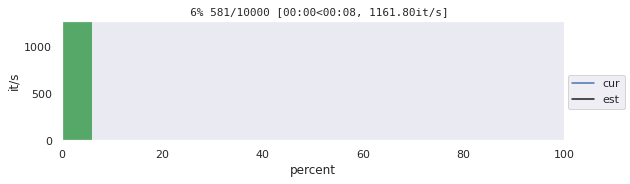

It took 0:00:07.830500. Average duration: 7.0 seconds.
Runs per second: 1428.5714285714287. Average: 1428.5714285714287.

Total time: 0:00:07.830500, approximated end: 2022-03-18 19:57:27.684707

-----------------------------------------------


Preparing Plot

+----+--------------+----------+-------+------------------+
|    | Parameter    |   Median | SD    | AIQR             |
|----+--------------+----------+-------+------------------|
|  0 | KD           |   124.96 | 5.559 | [114.37, 136.05] |
|  1 | µf           |   -19.99 | 0.157 | [-21.23, -18.82] |
|  2 | µc           |    10    | 0.618 | [9.69, 10.31]    |
|  3 | Failure rate |     0    | --    | --               |
+----+--------------+----------+-------+------------------+


MU APPROXIMATION 
Filename: ms_ACE_MU_APPROXIMATION_20220318_default


-----------------------------------------------

Specifications: 
KD                  125
uc                  -20
uf                   10
c_min                 0
c_max                10

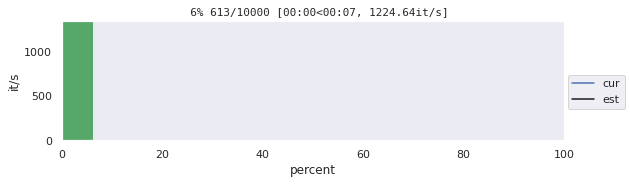

It took 0:00:07.803397. Average duration: 7.0 seconds.
Runs per second: 1428.5714285714287. Average: 1428.5714285714287.

Total time: 0:00:07.803397, approximated end: 2022-03-18 19:58:13.010411

-----------------------------------------------


Preparing Plot

+----+--------------+----------+-------+------------------+
|    | Parameter    |   Median | SD    | AIQR             |
|----+--------------+----------+-------+------------------|
|  0 | KD           |   125.06 | 5.549 | [114.61, 136.08] |
|  1 | µf           |   -20.01 | 0.156 | [-21.25, -18.85] |
|  2 | µc           |    10    | 0.616 | [9.69, 10.3]     |
|  3 | Failure rate |     0    | --    | --               |
+----+--------------+----------+-------+------------------+


In [36]:
canvas_height = 800
canvas_width = 1200
counter_fig = 0
root = tk.Tk()
root.tk.eval('::msgcat::mclocale en')
root.wm_title('Uncertainty Estimation ms-ACE')
canvas = tk.Canvas(root, height=canvas_height,width=canvas_width)
canvas.pack()
create_frames()
define_col_labels_opt()
print_labels_opts()
entry_1 = tk.Entry(frame_opt,bg='white',fg='black')
entry_1.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.1)
button_1 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_int(0,entry_1.get()))
button_1.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.1)
entry_2 = tk.Entry(frame_opt,bg='white',fg='black')
entry_2.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.135)
button_2 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(1,entry_2.get()))
button_2.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.135)
entry_3 = tk.Entry(frame_opt,bg='white',fg='black')
entry_3.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.17)
button_3 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(2,entry_3.get()))
button_3.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.17)
entry_4 = tk.Entry(frame_opt,bg='white',fg='black')
entry_4.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.205)
button_4 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(3,entry_4.get()))
button_4.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.205)
entry_5 = tk.Entry(frame_opt,bg='white',fg='black')
entry_5.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.24)
button_5 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(4,entry_5.get()))
button_5.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.24)
entry_6 = tk.Entry(frame_opt,bg='white',fg='black')
entry_6.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.275)
button_6 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(5,entry_6.get()))
button_6.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.275)
entry_7 = tk.Entry(frame_opt,bg='white',fg='black')
entry_7.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.31)
button_7 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(6,entry_7.get()))
button_7.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.31)
entry_8 = tk.Entry(frame_opt,bg='white',fg='black')
entry_8.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.345)
button_8 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(7,entry_8.get()))
button_8.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.345)
entry_9 = tk.Entry(frame_opt,bg='white',fg='black')
entry_9.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.38)
button_9 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(8,entry_9.get()))
button_9.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.38)
entry_10 = tk.Entry(frame_opt,bg='white',fg='black')
entry_10.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.415)
button_10 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(9,entry_10.get()))
button_10.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.415)
entry_11 = tk.Entry(frame_opt,bg='white',fg='black')
entry_11.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.45)
button_11 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_int(10,entry_11.get()))
button_11.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.45)
entry_12 = tk.Entry(frame_opt,bg='white',fg='black')
entry_12.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.485)
button_12 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_int(11,entry_12.get()))
button_12.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.485)
entry_13 = tk.Entry(frame_opt,bg='white',fg='black')
entry_13.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.52)
button_13 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_str(12,entry_13.get()))
button_13.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.52)
entry_14 = tk.Entry(frame_opt,bg='white',fg='black')
entry_14.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.555)
button_14 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(13,entry_14.get()))
button_14.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.555)
entry_15 = tk.Entry(frame_opt,bg='white',fg='black')
entry_15.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.59)
button_15 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(14,entry_15.get()))
button_15.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.59)
entry_16 = tk.Entry(frame_opt,bg='white',fg='black')
entry_16.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.625)
button_16 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_str(15,entry_16.get()))
button_16.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.625)
entry_17 = tk.Entry(frame_opt,bg='white',fg='black')
entry_17.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.66)
button_17 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(16,entry_17.get()))
button_17.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.66)
entry_18 = tk.Entry(frame_opt,bg='white',fg='black')
entry_18.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.695)
button_18 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_float(17,entry_18.get()))
button_18.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.695)
entry_19 = tk.Entry(frame_opt,bg='white',fg='black')
entry_19.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.73)
button_19 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_list(18,entry_19.get()))
button_19.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.73)
entry_20 = tk.Entry(frame_opt,bg='white',fg='black')
entry_20.place(relwidth=0.275,relheight=0.025,relx = 0.325, rely=0.765)
button_20 = tk.Button(frame_opt,text='->',bg='blue',fg='white',command=lambda: change_parameter_value_str(19,entry_20.get()))
button_20.place(relwidth=0.05,relheight=0.025,relx = 0.61, rely=0.765)
show_actual_parameter()
button_5 = tk.Button(frame_opt,text='Exit',bg='gray',fg='white',command= lambda: quit_program())
button_5.place(relwidth=0.275,relheight=0.05,relx = 0.675, rely=0.925)
button = tk.Button(frame_opt,text='Start',bg='gray',fg='white',command= lambda: Start_evaluation())
button.place(relwidth=0.275,relheight=0.05,relx = 0.35, rely=0.925)
button_2 = tk.Button(frame_opt,text='Reset Parameter',bg='gray',fg='white',command= lambda: reset_parameter())
button_2.place(relwidth=0.275,relheight=0.05,relx = 0.35, rely=0.825)
button_3 = tk.Button(frame_opt,text='Reset Program',bg='gray',fg='white',command= lambda: reset_canvas())
button_3.place(relwidth=0.275,relheight=0.05,relx = 0.675, rely=0.825)
button_4 = tk.Button(frame_opt,text='Only c Set',bg='gray',fg='white',command= lambda: create_c_in_adv_StandAlone(Parameter_imports))
button_4.place(relwidth=0.275,relheight=0.05,relx = 0.025, rely=0.825)
Result_txt_a = tk.Text(frame_res_txt, height=3, width=50)
Result_txt_a.place(relwidth=0.45,relheight=0.9,relx = 0.05, rely=0.05)
Result_txt_b = tk.Text(frame_res_txt, height=2, width=30)
Result_txt_b.place(relwidth=0.4,relheight=0.15,relx = 0.55, rely=0.7)
Result_txt = tk.Text(frame_res_txt, height=3, width=50)
Result_txt.place(relwidth=0.4,relheight=0.6,relx = 0.55, rely=0.05)
menu = tk.Menu(root)
root.config(menu = menu)
dateiMenu = tk.Menu(menu)
menu.add_cascade(label="File", menu = dateiMenu)
dateiMenu.add_command(label = "Save all", command = lambda: save_data('all'))
dateiMenu.add_command(label = "Save data", command = lambda: save_data('data'))
dateiMenu.add_command(label = "Save figure", command = lambda: save_data('figure'))
dateiMenu.add_separator()
dateiMenu.add_command(label = "exit", command = lambda: quit_program())
help_menue = tk.Menu(menu)
menu.add_cascade(label= "Help", menu = help_menue)
help_menue.add_command(label="Documentation", command = lambda: openNewWindow())
root.mainloop()